In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import defaultdict

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font = FontProperties(fname=font_path)

In [2]:
def load_cases(filepath, language):
    data = []
    failed_lines = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if language == 'zh':
                parts = line.replace(" ", "").split("\t")
                if len(parts) != 3 or parts[2] not in ["T", "F", "N"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            else:  # English
                parts = line.strip().split("\t|\t")
                if len(parts) != 3 or parts[2] not in ["Correct", "Incorrect", "Unknown"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            data.append({'guess': guess, 'title': title, 'label': label})
    df = pd.DataFrame(data)

    return df

In [3]:
# Load data
en_cases = load_cases("../data/en/cases.list", "en")
zh_cases = load_cases("../data/zh/cases.list", "zh")

en_titles = en_cases['title'].value_counts().sort_values(ascending=True)
zh_titles = zh_cases['title'].value_counts().sort_values(ascending=True)

if not os.path.exists('./figs'):
    os.makedirs('./figs')

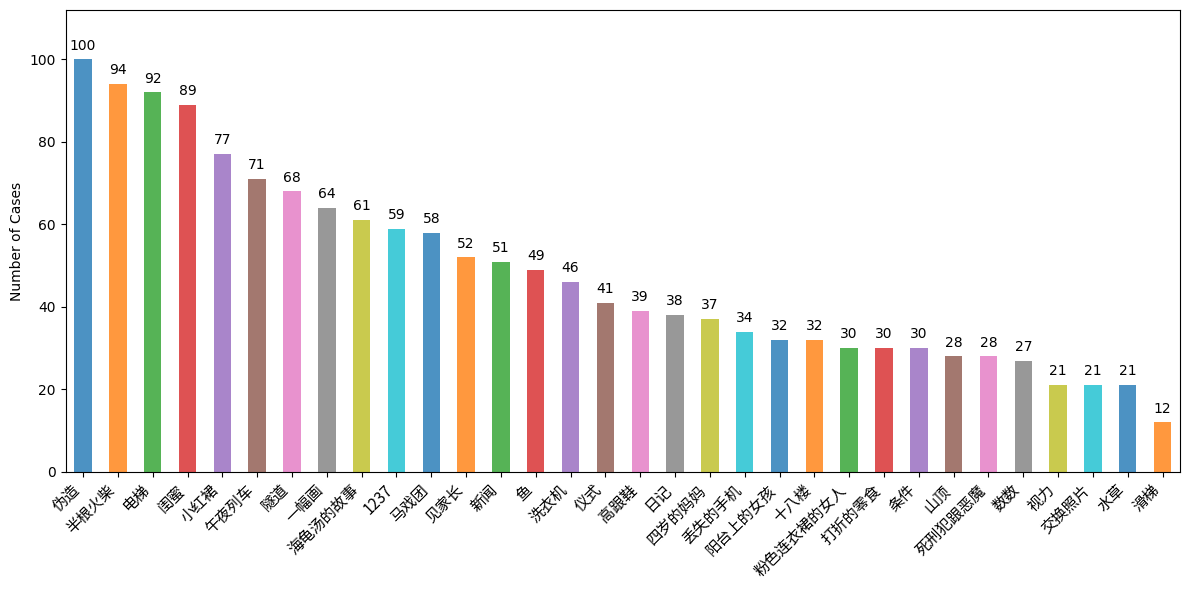

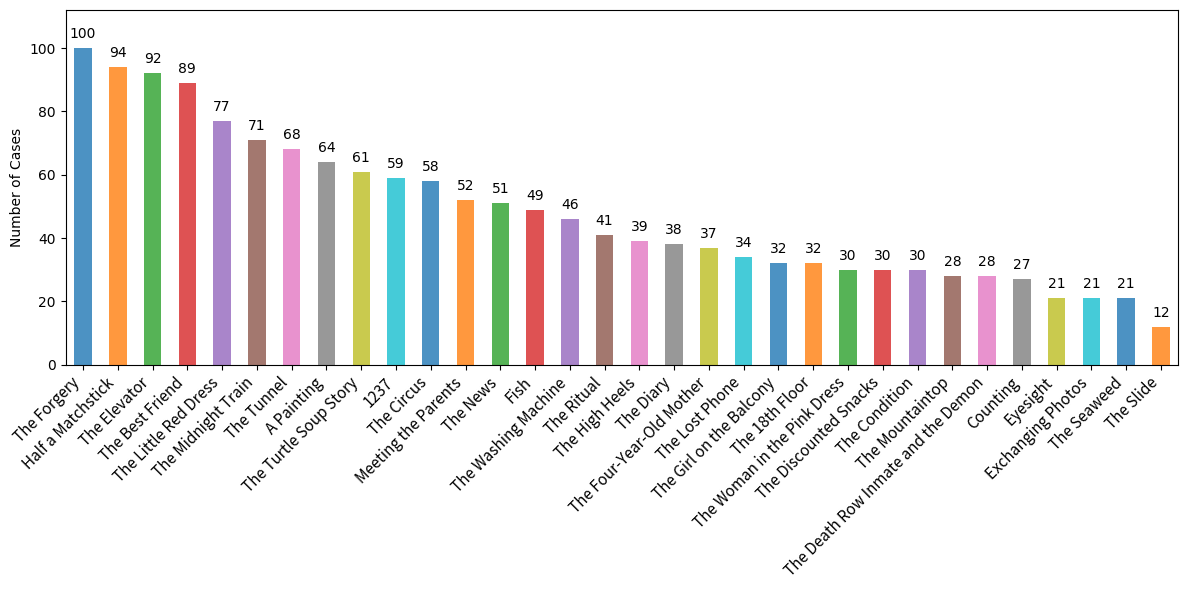

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
alpha = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
zh_titles_sorted = zh_titles.sort_values(ascending=False)  # 降序排序
zh_titles_sorted.plot(kind='bar', ax=ax, color=colors[:len(zh_titles_sorted)], alpha=alpha)
ax.set_ylabel('Number of Cases')
ax.set_ylim(0, zh_titles_sorted.max() * 1.12)
ax.set_xlabel('')

for i, v in enumerate(zh_titles_sorted.values):
    ax.annotate(f'{v}', xy=(i, v), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

for label in ax.get_xticklabels():
    label.set_fontproperties(font)
    label.set_fontsize(11)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

fig.savefig('./figs/zh_story_distribution.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(12, 6))
en_titles_sorted = en_titles.sort_values(ascending=False)
en_titles_sorted.plot(kind='bar', ax=ax, color=colors[:len(en_titles_sorted)], alpha=alpha)
ax.set_ylabel('Number of Cases')
ax.set_ylim(0, en_titles_sorted.max() * 1.12)
ax.set_xlabel('')

for i, v in enumerate(en_titles_sorted.values):
    ax.annotate(f'{v}', xy=(i, v), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

for label in ax.get_xticklabels():
    label.set_fontproperties(font)
    label.set_fontsize(11)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

fig.savefig('./figs/en_story_distribution.pdf', bbox_inches='tight')


In [5]:
def load_latest_cases(model_name, language, shot_type):
    """Load the latest cases."""
    filename_prefix = f"all_cases_{model_name}_{language}_shot{shot_type}"
    
    if language == "zh":
        log_folder = f"../logs/zh_with_{shot_type}shots"
    else:
        log_folder = f"../logs/en_with_{shot_type}shots"

    # Find all log files for the model
    log_files = glob.glob(os.path.join(log_folder, f"{filename_prefix}_*.json"))

    if not log_files:
        print(f"No log files found for model {model_name} in {log_folder}.")
        return None

    # Sort log files by the numerical part at the end of the filename
    log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)

    # Load the latest log file (the first one after sorting)
    latest_log_file = log_files[0]

    with open(latest_log_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data.get('cases', [])

In [6]:
def is_correct(model_judge, ground_truth, language):
    if language == 'zh':
        if ground_truth == "T":
            return model_judge == "T"
        else:
            return model_judge in ["F", "N"]
    else:
        if ground_truth == "Correct":
            return model_judge == "Correct"
        else:
            return model_judge in ["Incorrect", "Unknown"]
        
def calculate_story_accuracy(cases, language):
    story_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    total_correct = 0
    total_samples = len(cases)

    for case in cases:
        story_title = case["story_title"]
        model_judge = case["model_judge"]
        ground_truth = case["ground_truth"]

        correct = is_correct(model_judge, ground_truth, language)
        
        story_stats[story_title]['total'] += 1
        if correct:
            story_stats[story_title]['correct'] += 1
            total_correct += 1

    story_accuracies = {}
    for story_title, stats in story_stats.items():
        accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0
        story_accuracies[story_title] = accuracy

    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    average_story_accuracy = sum(story_accuracies.values()) / len(story_accuracies) if story_accuracies else 0.0

    return story_accuracies, overall_accuracy, average_story_accuracy

In [7]:
MODEL_NAMES = [
    'GPT_o1_Preview',
    'GPT_o1_Mini',
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

all_zh_story_accuracies = defaultdict(list)
all_en_story_accuracies = defaultdict(list)

all_zh_overall_accuracies = 0
all_en_overall_accuracies = 0

all_zh_avg_story_accuracies = 0
all_en_avg_story_accuracies = 0

for model_name in MODEL_NAMES:
    zh_cases = load_latest_cases(model_name, "zh", "0")
    en_cases = load_latest_cases(model_name, "en", "0")

    zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy = calculate_story_accuracy(zh_cases, "zh")
    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy = calculate_story_accuracy(en_cases, "en")

    all_zh_overall_accuracies += zh_overall_accuracy
    all_en_overall_accuracies += en_overall_accuracy

    all_zh_avg_story_accuracies += zh_avg_story_accuracy
    all_en_avg_story_accuracies += en_avg_story_accuracy

    for story_title, accuracy in zh_story_accuracies.items():
        all_zh_story_accuracies[story_title].append(accuracy)

    for story_title, accuracy in en_story_accuracies.items():
        all_en_story_accuracies[story_title].append(accuracy)

all_zh_overall_accuracies /= len(MODEL_NAMES)
all_en_overall_accuracies /= len(MODEL_NAMES)

all_zh_avg_story_accuracies /= len(MODEL_NAMES)
all_en_avg_story_accuracies /= len(MODEL_NAMES)

average_zh_story_accuracies = {story_title: np.mean(accuracies) for story_title, accuracies in all_zh_story_accuracies.items()}
average_en_story_accuracies = {story_title: np.mean(accuracies) for story_title, accuracies in all_en_story_accuracies.items()}

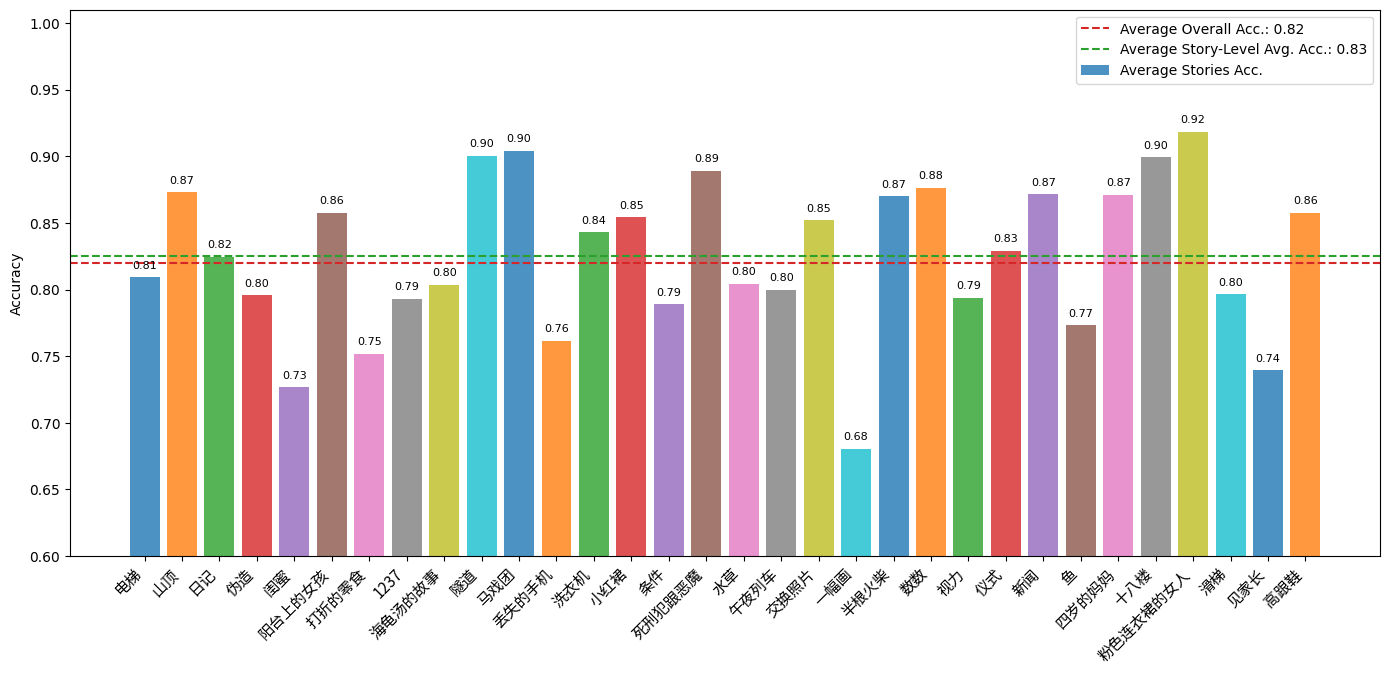

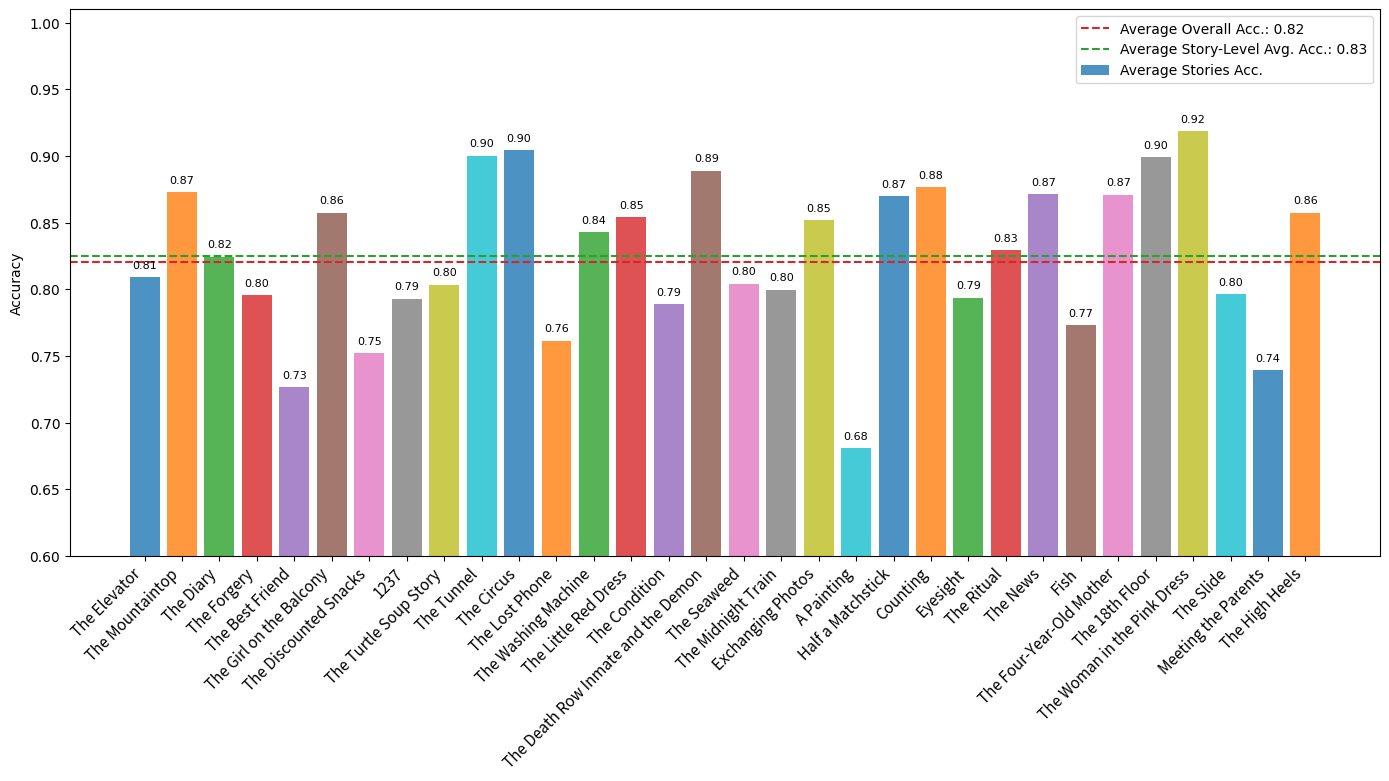

In [8]:
# Define the color scheme to match the provided code
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
alpha = 0.8

def plot_chinese_accuracy(average_zh_story_accuracies, all_zh_overall_accuracies, all_zh_avg_story_accuracies):
    fig, ax = plt.subplots(figsize=(14, 6))

    story_titles = list(average_zh_story_accuracies.keys())
    story_values = list(average_zh_story_accuracies.values())

    # Use the colors defined above
    bars = ax.bar(story_titles, story_values, color=colors[:len(story_titles)], alpha=alpha, label='Average Stories Acc.')
    ax.set_ylim(0.6, 1.01)  # Y-axis range

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    # Use consistent line colors
    ax.axhline(all_zh_overall_accuracies, color='#d62728', linestyle='--',
               label=f'Average Overall Acc.: {all_zh_overall_accuracies:.2f}')
    ax.axhline(all_zh_avg_story_accuracies, color='#2ca02c', linestyle='--',
               label=f'Average Story-Level Avg. Acc.: {all_zh_avg_story_accuracies:.2f}')

    ax.set_ylabel('Accuracy')
    ax.legend()
    plt.tight_layout()
    plt.xticks(fontproperties=font, fontsize=11, rotation=45, ha='right')  # Tilt X-axis labels
    plt.show()

    fig.savefig('./figs/zh_story_acc_comparison.pdf', bbox_inches='tight')

def plot_english_accuracy(average_en_story_accuracies, average_cn_story_accuracies, all_cn_overall_accuracies, all_cn_avg_story_accuracies):
    fig, ax = plt.subplots(figsize=(14, 6))

    story_titles = list(average_en_story_accuracies.keys())
    story_values = list(average_cn_story_accuracies.values())

    # Use the same colors
    bars = ax.bar(story_titles, story_values, color=colors[:len(story_titles)], alpha=alpha, label='Average Stories Acc.')
    ax.set_ylim(0.6, 1.01)  # Y-axis range

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    # Use consistent line colors
    ax.axhline(all_cn_overall_accuracies, color='#d62728', linestyle='--',
               label=f'Average Overall Acc.: {all_cn_overall_accuracies:.2f}')
    ax.axhline(all_cn_avg_story_accuracies, color='#2ca02c', linestyle='--',
               label=f'Average Story-Level Avg. Acc.: {all_cn_avg_story_accuracies:.2f}')

    ax.set_ylabel('Accuracy')
    ax.legend()
    plt.tight_layout()
    plt.xticks(fontproperties=font, fontsize=11, rotation=45, ha='right')  # Tilt X-axis labels
    plt.show()

    fig.savefig('./figs/en_story_acc_comparison.pdf', bbox_inches='tight')

# Call the plotting functions
plot_chinese_accuracy(average_zh_story_accuracies, all_zh_overall_accuracies, all_zh_avg_story_accuracies)
plot_english_accuracy(average_en_story_accuracies, average_zh_story_accuracies, all_zh_overall_accuracies, all_zh_avg_story_accuracies)
